## Hadleigh's Skew-T diagram

#### Uses P Austin's Skew-T Temperature and Dewpoint map as a base .

    * Plots isohumes using a rootfinder to solve for an list of mixing ratios
    
    * Shortcuts the moist adiabat problem by using R Stull's finite difference equations to solve for raising a saturated parcel 



In [168]:
# ===================
# Imports
# ===================

import numpy as np
import pandas as pd
import h5py
from pprint import pformat
import matplotlib.pyplot as plt
from scipy import optimize as op
%matplotlib inline

from a405skewT.makeSkew import makeSkewDry
import a405skewT.makeSkew
from importlib import reload
reload(a405skewT.makeSkew)

<module 'a405skewT.makeSkew' from '/Users/hadleighs/Documents/UBC_1516/ATSC_405/405_repos/A405/a405skewT/makeSkew.py'>

In [169]:
# ======================
# Functions
# ======================

def convertSkewToTemp(xcoord, press, skew):
    """
    convertSkewToTemp(xcoord, press, skew)
    Determines temperature from knowledge of a plotting coordinate
    system and corresponding plot skew.
    Parameters
    - - - - - -
    xcoord : int
        X coordinate in temperature plotting coordinates.
    press : float
        Pressure (hPa).
    skew : int
        Skew of a given coordinate system.
    Returns
    - - - -
    Temp : float
        Converted temperature in degC.
    Examples
    - - - - -
    >>> convertSkewToTemp(300, 8.e4, 30)
    638.6934574096806
    """
    Temp = xcoord  + skew * np.log(press);
    return Temp

def convertTempToSkew(Temp, press, skew):
    """
    convertTempToSkew(Temp, press, skew)
    Determines the transformed temperature in plotting coordinates.
    Parameters
    - - - - - -
    Temp : float
        Temperature (degC)
    press : float
        Pressure (hPa).
    skew : int
        Designated skew factor of temperature.
    Returns
    - - - -
    tempOut : float
        Converted temperature (degC).
    Examples
    - - - - -
    >>> convertTempToSkew(30., 8.e4, 30)
    -308.69345740968055
    """
    tempOut = Temp - skew * np.log(press);
    return tempOut



# ============================================
# functions for rootfinder to use to get isohumes
# ============================================

def find_isohume_temp(Press, r):
    """
    takes the pressure then returns temps that make mixing ratio true
    """
    
    def find_rs(Temp, Press, r):
        """
        function we want the root of; thompkins eqn 2.20
        should be zero when the temp is correct for mixing ratio rs at a given pressure
        """
        epsilon = 0.622
        es = find_es(Temp)
        return ((epsilon * es) / (Press - es) - r)
            
    def find_es(Temp):
        """
        helper function to get es for a given temp from thompkins eqn 2.15
        """
        return (611.2 * np.exp((17.67 * Temp) / (Temp + 243.5))) / 100.
            
    def find_temps(Press, r):
        """
        finds the roots of find_rs, -30 to 30 deg C gives realistic atmosphere
        """
        Temp = op.zeros.brentq(find_rs, -40, 40, args=(Press, r))
        return Temp
    
    return(find_temps(Press,r))


# ==========================================================
# using stulls finite differnces to get moist adiabat line
# ==========================================================

# saturation vapour pressure es
def eqn_41a(Temp):

    Temp=Temp+273.15
    Rv=461.
    To=273.15
    eo=6.113
    L=2.5e6
    term2 = (1/To) - (1/Temp)
    term2 = term2 * (L/Rv)
    return eo * np.exp(term2)

# sat mixing ratio rs g/g
def eqn_45(Temp, Press):
    
    epsilon = 0.622
    es = eqn_41a(Temp)
    return (epsilon*es)/(Press-es)

# delT over delP
def eqn_438b(Temp, Press):
    
    rs=eqn_45(Temp, Press)
    Temp = Temp+273.15
    a = 0.28571
    b = 1.35e7
    c = 2488.4
    numerator = (a*Temp) + (c*rs)
    denom = Press * (1+((b*rs)/(Temp**2)))
    return numerator/denom

# next temp up the adiabat T2
def eqn_439(Temp, P1, P2):
    
    ToverP = eqn_438b(Temp, P2)
    return (Temp + (ToverP * (P2-P1)))


======================================================================================================================

### Hadleigh's Solution:

(Hilo Sounding - Hawaii)

======================================================================================================================

reading file: hilo.h5

empty key:  TITLE
empty key:  CLASS
empty key:  VERSION
empty key:  PYTABLES_FORMAT_VERSION


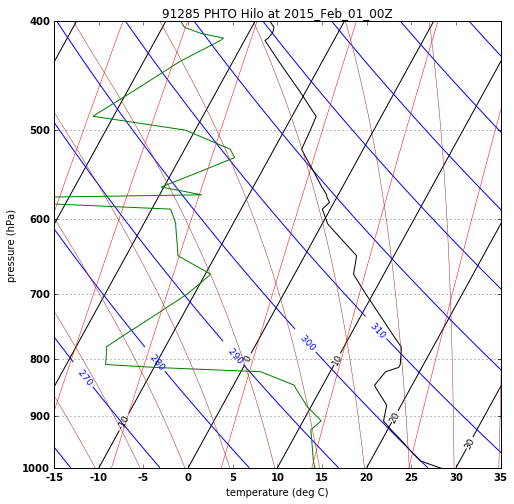

In [170]:
# ==========================================================================================================

# Hadleigh's Solution:

#(Hilo Sounding - Hawaii)

# ===========================================================================================================

# %config InlineBackend.close_figures=False
fig,ax =plt.subplots(1,1,figsize=(8,8))
ax,skew = makeSkewDry(ax)

filename='hilo.h5';
print('reading file: %s\n' %filename)

attributes={}
with h5py.File(filename,'r') as f:
    keys=f.attrs.keys()
    for key in keys:
        try:
            attributes[key]=f.attrs[key]
        except IOError:
            print('empty key: ',key)

separator= '\n' + '+'*30 + '\n'
sounding_dict={}
with pd.HDFStore(filename,'r') as store:
    times=store.keys()
    for the_time in times:
        sounding_dict[the_time]=store[the_time]
sounding=sounding_dict[times[3]]
title_string=attributes['header']
index=title_string.find(' Observations at')
location=title_string[:index]
title='{} at {}'.format(location,times[0][2:])
units=attributes['units'].split(';')
units_dict={}
for count,var in enumerate(sounding.columns):
    units_dict[var]=units[count]

    
# ============================================================================================
# Hadleigh's work for a list of isohumes and moist adiabats
# ============================================================================================

# reducing the amount of atmosphere we iterate over since we are only plotting 1000-400hPa
sample_sounding=sounding[sounding['pres']>=400]
parameter_list=zip(sample_sounding['temp'],sample_sounding['dwpt'],sample_sounding['pres'])

xcoord_T=[]
xcoord_Td=[]

# Phil's original temp and dewpt plot
for a_temp,a_dew,a_pres in parameter_list:
    xcoord_T.append(convertTempToSkew(a_temp,a_pres,skew))
    xcoord_Td.append(convertTempToSkew(a_dew,a_pres,skew))
ax.plot(xcoord_T,sample_sounding['pres'],color='k',label='temp')
ax.plot(xcoord_Td,sample_sounding['pres'],color='g',label='dew')

# list of mixing ratios to iterate over
mixing_ratios = [0.5, 1., 2., 5., 10., 20.]
 
# geting isohumes for each mixing ratio
for r in mixing_ratios:
    r=r/1000.
    isohumes = [find_isohume_temp(press, r) for press in sample_sounding['pres']]
    parameter_list=zip(isohumes, sample_sounding['pres'])
    xcoord_r = []
    for a_isohume, a_pres in parameter_list:
        xcoord_r.append(convertTempToSkew(a_isohume,a_pres,skew))
    ax.plot(xcoord_r,sample_sounding['pres'],color='r',label='r',linestyle='-', linewidth=.5)

    
# list of suface temps to work upwards from for moist adaibats
temps_list = np.arange(35.,-15.,-5)

# working upwards along moist adiabat and plotting curve
for temp in temps_list:
    press_list = sample_sounding['pres']
    theta = np.zeros_like(press_list)
    theta[0] = temp
    for i in range(0,len(theta)-1):
        P1 = press_list[i]
        P2 = press_list[(i+1)]
        theta[(i+1)] = eqn_439(theta[i], P1, P2)

        parameter_list=zip(theta, sample_sounding['pres'])
        xcoord_theta = []
    for a_theta, a_pres in parameter_list:
        xcoord_theta.append(convertTempToSkew(a_theta,a_pres,skew))
    last_index = len(sample_sounding)
    theta[last_index-1] = theta[last_index-2]
    ax.plot(xcoord_theta,sample_sounding['pres'],color='brown',label='theta',linestyle='-', linewidth=.5)

# make plot
ax.set(title=title)
ax.set(ylim=[1000,400])
fig.canvas.draw()
